# **📄 Document type classification baseline code**
> 문서 타입 분류 대회에 오신 여러분 환영합니다! 🎉     
> 아래 baseline에서는 ResNet 모델을 로드하여, 모델을 학습 및 예측 파일 생성하는 프로세스에 대해 알아보겠습니다.

## Contents
- Prepare Environments
- Import Library & Define Functions
- Hyper-parameters
- Load Data
- Train Model
- Inference & Save File


## 1. Prepare Environments

* 데이터 로드를 위한 구글 드라이브를 마운트합니다.
* 필요한 라이브러리를 설치합니다.

In [ ]:
# 필요한 라이브러리를 설치합니다.
!pip install timm
# --- [OpenCV 설치] ---
# Albumentations와 함께 사용하기 위해 OpenCV를 설치합니다.
!pip install opencv-python-headless -q

## 2. Import Library & Define Functions
* 학습 및 추론에 필요한 라이브러리를 로드합니다.
* 학습 및 추론에 필요한 함수와 클래스를 정의합니다.

In [1]:
import os
os.environ["WANDB_START_METHOD"] = "thread"
import time
import random
import glob

import cv2
import timm
import torch
import ttach as tta
import albumentations as A
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam, AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, CosineAnnealingWarmRestarts
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold

In [ ]:
# --- 1. W&B 설치 및 로그인 ---

# W&B 라이브러리를 설치합니다.
!pip install wandb -q

# W&B에 로그인합니다.
# 실행 후 나오는 입력창에 복사해둔 API Key를 붙여넣으세요.
import wandb
wandb.login()

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [3]:
# --- [추가] 이미지 기울기 보정(Deskew) 함수 ---
def deskew(image):
    """이미지의 기울기를 감지하고 보정합니다."""
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray) # 배경을 검정, 글자를 흰색으로
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
    
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]
    
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
        
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    
    return rotated

# --- [추가] 가로세로 비율 유지 리사이즈 및 패딩 함수 ---
def resize_and_pad(image, target_size=(224, 224)):
    """이미지의 가로세로 비율을 유지하며 리사이즈하고, 남는 공간을 패딩합니다."""
    h, w, c = image.shape
    target_h, target_w = target_size

    scale = min(target_w / w, target_h / h)
    new_w, new_h = int(w * scale), int(h * scale)
    
    if new_w > target_w: new_w = target_w
    if new_h > target_h: new_h = target_h
        
    resized_image = cv2.resize(image, (new_w, new_h))
    
    pad_w = (target_w - new_w) // 2
    pad_h = (target_h - new_h) // 2
    
    padded_image = np.full((target_h, target_w, c), 0, dtype=np.uint8)
    padded_image[pad_h:pad_h+new_h, pad_w:pad_w+new_w] = resized_image
    
    return padded_image

# --- 데이터셋 클래스 정의 (고급 전처리 적용) ---
class ImageDataset(Dataset):
    def __init__(self, df, data_path, transform=None, img_size=224):
        self.df = df.values
        self.path = data_path
        self.transform = transform
        self.img_size = img_size # 모델별 이미지 크기를 받음

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df[idx]
        img_path = os.path.join(self.path, name)
        
        image = cv2.imread(img_path)
        if image is None:
            print(f"Warning: Could not read image {img_path}.")
            # 문제가 있는 이미지는 건너뛰고 다음 이미지를 로드
            return self.__getitem__((idx + 1) % len(self.df))
        
        # --- 전처리 파이프라인 ---
        # 1. 기울기 보정
        #image = deskew(image)
        
        # 2. 비율 유지 리사이즈 (모델별 img_size 적용)
        #image = resize_and_pad(image, target_size=(self.img_size, self.img_size))
        
        # 3. BGR -> RGB 변환 (Albumentations 및 모델 입력 표준)
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # 4. Albumentations 데이터 증강
        if self.transform:
            image = self.transform(image=image)['image']
            
        return image, target

In [4]:
# --- [수정] one epoch 학습을 위한 함수 (AMP 적용) ---
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(loader, model, optimizer, loss_fn, device, accumulation_steps=1):
    scaler = GradScaler() # AMP를 위한 GradScaler 초기화
    model.train()
    train_loss = 0
    preds_list, targets_list = [], []
    optimizer.zero_grad()

    pbar = tqdm(loader)
    for i, (image, targets) in enumerate(pbar):
        image, targets = image.to(device), targets.to(device)

        # autocast 컨텍스트 안에서 연산을 수행하면 자동으로 FP16이 적용됩니다.
        with autocast():
            preds = model(image)
            loss = loss_fn(preds, targets)
            loss = loss / accumulation_steps

        # loss.backward() 대신 scaler를 사용합니다.
        scaler.scale(loss).backward()

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer) # optimizer.step() 대신 scaler 사용
            scaler.update()
            optimizer.zero_grad()

        train_loss += loss.item() * accumulation_steps
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())
        pbar.set_description(f"Loss: {loss.item()*accumulation_steps:.4f}")

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')
    return {"train_loss": train_loss, "train_acc": train_acc, "train_f1": train_f1}

In [5]:
# --- [수정] 모델 평가를 위한 함수 (AMP 적용) ---
from torch.cuda.amp import autocast

def evaluate(loader, model, loss_fn, device):
    model.eval()
    val_loss = 0
    preds_list, targets_list = [], []
    with torch.no_grad():
        for image, targets in tqdm(loader, desc="Validating"):
            image, targets = image.to(device), targets.to(device)

            with autocast(): # 추론 시에도 autocast 적용
                preds = model(image)
                loss = loss_fn(preds, targets)

            val_loss += loss.item()
            preds_list.extend(preds.argmax(dim=1).cpu().numpy())
            targets_list.extend(targets.cpu().numpy())

    val_f1 = f1_score(targets_list, preds_list, average='macro')
    return {"val_loss": val_loss / len(loader), "val_f1": val_f1}

In [ ]:
# --- 2. EDA 및 W&B 리포팅 ---
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm

# W&B Run 시작: EDA 과정을 기록할 프로젝트를 생성합니다.
with wandb.init(project="document-classification-eda", job_type="eda") as run:
    
    # 1. 원본 학습 데이터 로드
    full_train_df = pd.read_csv("/home/data/data/train.csv")
    
    # 2. W&B 테이블 생성: EDA 결과를 담을 표를 정의합니다.
    eda_table = wandb.Table(columns=[
        "ID", 
        "Image", 
        "Target", 
        "Width", 
        "Height", 
        "Aspect Ratio"
    ])
    
    # 3. 각 이미지의 정보를 테이블에 추가
    print("EDA 테이블을 생성하고 W&B에 업로드하는 중입니다...")
    for idx, row in tqdm(full_train_df.iterrows(), total=len(full_train_df)):
        image_id = row["ID"]
        target = row["target"]
        image_path = f"/home/data/data/train/{image_id}"
        
        # 이미지 파일을 열어 크기 정보 추출
        with Image.open(image_path) as img:
            width, height = img.size
            aspect_ratio = width / height if height > 0 else 0
        
        # 테이블에 행(row) 추가
        eda_table.add_data(
            image_id,
            wandb.Image(image_path), # 이미지를 W&B 형식으로 변환
            target,
            width,
            height,
            f"{aspect_ratio:.2f}"
        )
        
    # 4. 생성된 테이블을 W&B Run에 기록(log)
    run.log({"EDA_Table": eda_table})
    
    print("\n✅ W&B EDA 리포팅 완료! 위 wandb 링크를 클릭하여 대시보드를 확인하세요.")

In [ ]:
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import wandb

# W&B Run 시작: 테스트 데이터셋 EDA 과정을 기록할 프로젝트를 생성합니다.
with wandb.init(project="document-classification-test-eda", job_type="eda") as run:

    # 1. 테스트 데이터 로드 (sample_submission.csv 활용)
    test_df = pd.read_csv("/home/data/data/sample_submission.csv")

    # 2. W&B 테이블 생성: 테스트 데이터셋의 EDA 결과를 담을 표를 정의합니다.
    # 'target' 열이 없으므로 해당 열은 제외합니다.
    eda_table = wandb.Table(columns=[
        "ID",
        "Image",
        "Width",
        "Height",
        "Aspect Ratio"
    ])

    # 3. 각 테스트 이미지의 정보를 테이블에 추가
    print("테스트 데이터셋 EDA 테이블을 생성하고 W&B에 업로드하는 중입니다...")
    for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
        image_id = row["ID"]
        # 테스트 이미지 경로 설정
        image_path = f"/home/data/data/test/{image_id}"

        # 이미지 파일을 열어 크기 정보 추출
        try:
            with Image.open(image_path) as img:
                width, height = img.size
                aspect_ratio = width / height if height > 0 else 0
        except FileNotFoundError:
            # 혹시 모를 파일 누락에 대비
            width, height, aspect_ratio = -1, -1, -1

        # 테이블에 행(row) 추가
        eda_table.add_data(
            image_id,
            wandb.Image(image_path), # 이미지를 W&B 형식으로 변환
            width,
            height,
            f"{aspect_ratio:.2f}"
        )

    # 4. 생성된 테이블을 W&B Run에 기록(log)
    run.log({"Test_EDA_Table": eda_table})

    print("\n✅ W&B EDA 리포팅 완료! 위 wandb 링크를 클릭하여 대시보드를 확인하세요.")

## 3. Hyper-parameters
* 학습 및 추론에 필요한 하이퍼파라미터들을 정의합니다.

In [7]:
# --- 기본 설정 ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
data_path = 'datasets_fin/'
num_classes = 17 # 총 클래스 개수

# --- 앙상블을 위한 모델 목록 정의 ---
# 각 모델에 맞는 이름, 이미지 크기, 배치 사이즈를 딕셔너리 형태로 관리합니다.
model_configs = [
    #{
        #"model_name": 'convnext_xlarge_in22k',
        #"img_size": 384,
        #"batch_size": 16, # GPU 메모리 부족 시 8로 줄이세요.
    #},
    #{
        #"model_name": 'swin_large_patch4_window7_224',
        #"img_size": 224,
        #"batch_size": 16,
    #},
    {
        "model_name": 'maxvit_base_tf_512',
        "img_size": 512,
        "batch_size": 8,
    },
    {
        "model_name": 'eva02_base_patch14_224.mim_in22k',
        "img_size": 224,
        "batch_size": 32,
    }
]

# --- K-Fold 및 공통 학습 설정 ---
N_SPLITS = 5      # K-Fold 횟수 (시간이 부족하면 3으로 줄여서 테스트)
LR = 1e-3
EPOCHS = 20     # 최대 에폭 수. Early Stopping으로 조기에 중단될 수 있음.
PATIENCE = 3      # 조기 종료를 위한 대기 횟수
num_workers = 2

Using device: cuda


In [8]:
# --- [신규] 정제된 데이터 증강 전략 정의 ---

def get_transforms(img_size):
    """
    과한 왜곡은 줄이고, 현실적인 변형에 집중한
    정제된 데이터 증강(transform) 파이프라인을 반환하는 함수입니다.
    """
    # 학습용 데이터 증강 (정제된 버전)
    trn_transform = A.Compose([
        A.Resize(height=img_size, width=img_size),

        # --- 강도를 낮춘 기하학적 변형 ---
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.03, rotate_limit=60, p=0.7), # 회전 각도와 크기 조절 강도 감소

        # 강력한 왜곡은 낮은 확률로 적용
        A.OneOf([
            A.Perspective(scale=(0.02, 0.05), p=0.7), # 왜곡 강도 감소
            A.GridDistortion(num_steps=5, distort_limit=0.2, p=0.7), # 왜곡 강도 감소
            A.ElasticTransform(alpha=1, sigma=30, alpha_affine=30, p=0.7) # 왜곡 강도 감소
        ], p=0.4), # 적용 확률을 50% -> 40%로 낮춤

        # --- 현실적인 사진 품질 저하 ---
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7), # 대비 변화 강도 감소
        A.RandomShadow(p=0.4),
        A.OneOf([
            A.GaussianBlur(blur_limit=(3, 5), p=0.7), # 블러 강도 감소
            A.MotionBlur(blur_limit=(3, 5), p=0.7),
        ], p=0.4), # 적용 확률을 50% -> 30%로 낮춤

        A.ImageCompression(quality_lower=80, quality_upper=100, p=0.5), # 적용 확률 및 압축률 조정
        A.CoarseDropout(max_holes=4, max_height=int(img_size*0.08), max_width=int(img_size*0.08), min_holes=1, fill_value=0, p=0.3), # 구멍 크기와 개수, 확률 감소

        # 정규화 및 텐서 변환
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    # 검증 및 테스트용은 동일
    tst_transform = A.Compose([
        A.Resize(height=img_size, width=img_size),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])
    
    return trn_transform, tst_transform

🎨 정제된 데이터 증강 예시:


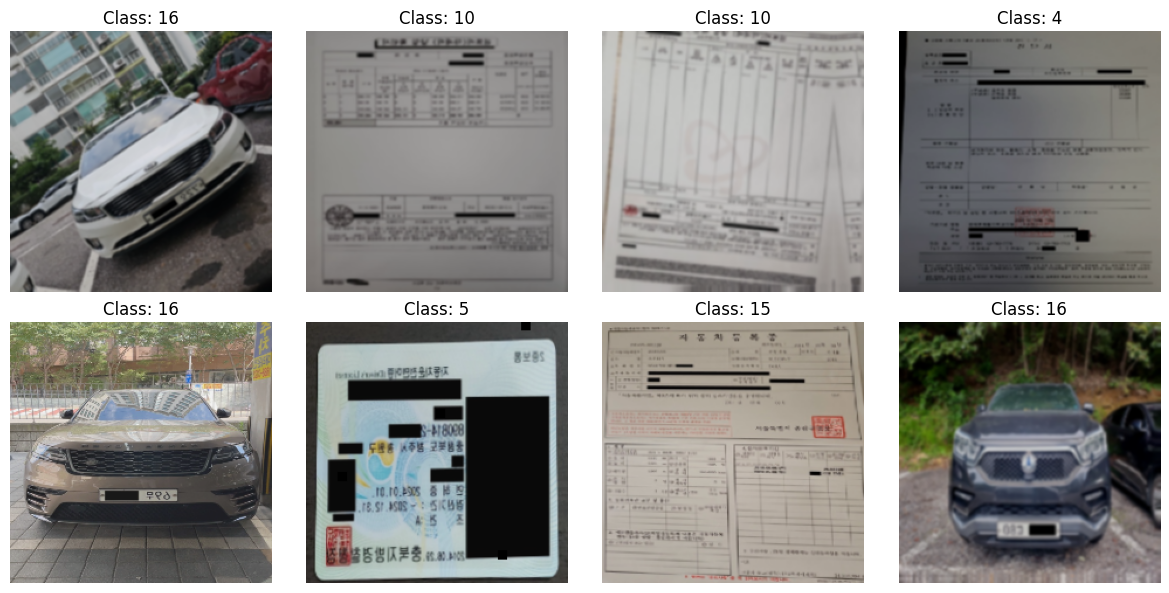

In [9]:
# --- 정제된 데이터 증강 시각화 ---
import pandas as pd
import matplotlib.pyplot as plt

# 시각화를 위해 Normalize와 ToTensorV2를 제외한 증강 파이프라인을 임시로 만듭니다.
vis_transform_refined = A.Compose([
    A.Resize(height=224, width=224),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.03, scale_limit=0.03, rotate_limit=70, p=0.6),
    A.OneOf([
        A.Perspective(scale=(0.02, 0.05), p=1.0),
        A.GridDistortion(distort_limit=0.2, p=1.0),
    ], p=0.3),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.7),
    A.GaussianBlur(blur_limit=(3, 5), p=0.3),
    A.CoarseDropout(max_holes=4, p=0.3),
])

# ▼▼▼▼▼ [수정] 이 부분을 변경합니다 ▼▼▼▼▼
# 1. 먼저 CSV 파일을 Pandas DataFrame으로 불러옵니다.
vis_df = pd.read_csv("/home/data/data/train.csv")

# 2. ImageDataset에 파일 경로 대신 위에서 만든 DataFrame(vis_df)을 전달합니다.
vis_dataset_refined = ImageDataset(vis_df, "/home/data/data/train/", transform=vis_transform_refined)
# ▲▲▲▲▲ 여기까지 변경합니다 ▲▲▲▲▲

print("🎨 정제된 데이터 증강 예시:")
plt.figure(figsize=(12, 6))
for i in range(8):
    image, label = vis_dataset_refined[i]
    plt.subplot(2, 4, i+1)
    plt.imshow(image)
    plt.title(f"Class: {label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

## 4. Load Data
* 학습, 테스트 데이터셋과 로더를 정의합니다.

## 5. Train Model
* 모델을 로드하고, 학습을 진행합니다.

In [ ]:
# ✅ [수정] 셀 전체를 아래 코드로 교체하세요.

# --- AMP(Automatic Mixed Precision)와 CuDNN 벤치마크 설정 ---
import torch.cuda.amp as amp
torch.backends.cudnn.benchmark = True

# --- 그래디언트 축적 스텝 정의 ---
ACCUMULATION_STEPS = 4 # 4 스텝마다 가중치 업데이트 (실질적 배치 사이즈: batch_size * 4)

# --- 최종 통합 학습 루프 (최적화 및 전처리 적용) ---
full_train_df = pd.read_csv("/home/data/data/train.csv")

for config in model_configs:
    model_name = config['model_name']
    img_size = config['img_size']
    batch_size = config['batch_size']
    
    print(f"======================================================")
    print(f"   Training Model: {model_name.upper()}")
    print(f"======================================================")
    
    kfold = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

    for fold, (train_idx, val_idx) in enumerate(kfold.split(full_train_df, full_train_df['target'])):
        print(f"----------- FOLD {fold+1}/{N_SPLITS} -----------")
        
        #run = wandb.init(project="document-classification-train", group=model_name, name=f"{model_name}-fold-{fold}", config=config, reinit=True)

        train_df, val_df = full_train_df.iloc[train_idx], full_train_df.iloc[val_idx]
        
        # --- 데이터셋 및 로더 생성 (모델별 img_size 전달) ---
        trn_transform, tst_transform = get_transforms(img_size=img_size) 
        trn_dataset = ImageDataset(train_df, "/home/data/data/train/", transform=trn_transform, img_size=img_size)
        val_dataset = ImageDataset(val_df, "/home/data/data/train/", transform=tst_transform, img_size=img_size)
        
        trn_loader = DataLoader(trn_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

        model = timm.create_model(model_name, pretrained=True, num_classes=num_classes).to(device)
        
        # (옵티마이저 설정은 기존과 동일)
        optimizer = AdamW(model.parameters(), lr=LR) 
            
        loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
        scheduler = CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)
        scaler = amp.GradScaler()
        best_f1, trigger_times = 0.0, 0

        for epoch in range(EPOCHS):
            model.train()
            all_preds, all_targets = [], []
            optimizer.zero_grad()
            
            for i, (image, target) in enumerate(tqdm(trn_loader, desc=f"Epoch {epoch+1} Training")):
                image, target = image.to(device), target.to(device)
                
                with amp.autocast():
                    preds = model(image)
                    loss = loss_fn(preds, target)
                    loss = loss / ACCUMULATION_STEPS
                
                scaler.scale(loss).backward()
                
                if (i + 1) % ACCUMULATION_STEPS == 0:
                    scaler.step(optimizer)
                    scaler.update()
                    optimizer.zero_grad()
                
                all_preds.extend(preds.argmax(1).detach().cpu().numpy())
                all_targets.extend(target.detach().cpu().numpy())
            
            train_f1 = f1_score(all_targets, all_preds, average='macro')
            
            val_ret = evaluate(val_loader, model, loss_fn, device=device)
            current_f1 = val_ret['val_f1']
            print(f"Epoch {epoch+1:02}/{EPOCHS} -> Train F1: {train_f1:.4f} | Val F1: {current_f1:.4f}")
            
            scheduler.step()
            #wandb.log({"epoch": epoch + 1, "train_f1": train_f1, "val_f1": current_f1, "learning_rate": optimizer.param_groups[0]['lr']})

            if current_f1 > best_f1:
                best_f1 = current_f1
                torch.save(model.state_dict(), f'best_model_{model_name}_fold_{fold}.pth')
                trigger_times = 0
            else:
                trigger_times += 1
                if trigger_times >= PATIENCE:
                    print(f"Early stopping at epoch {epoch+1}.")
                    break
                    
        print(f"Fold {fold+1} Best F1: {best_f1:.4f}\n")
        
        #wandb.summary["best_val_f1"] = best_f1
        #run.finish()

        del model, optimizer, scheduler, scaler, trn_loader, val_loader, trn_dataset, val_dataset 
        import gc
        gc.collect()
        torch.cuda.empty_cache()

   Training Model: MAXVIT_BASE_TF_512
----------- FOLD 1/5 -----------


Validating: 100%|██████████| 40/40 [00:06<00:00,  6.36it/s]


Epoch 01/20 -> Train F1: 0.5935 | Val F1: 0.7425


Validating: 100%|██████████| 40/40 [00:05<00:00,  8.00it/s]


Epoch 02/20 -> Train F1: 0.7990 | Val F1: 0.8186


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.98it/s]


Epoch 03/20 -> Train F1: 0.8337 | Val F1: 0.8456


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.94it/s]


Epoch 04/20 -> Train F1: 0.8688 | Val F1: 0.8638


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.99it/s]


Epoch 05/20 -> Train F1: 0.8956 | Val F1: 0.8928


Validating: 100%|██████████| 40/40 [00:05<00:00,  7.96it/s]


Epoch 06/20 -> Train F1: 0.9281 | Val F1: 0.8699


Epoch 7 Training:  31%|███       | 48/157 [00:19<00:43,  2.52it/s]

# 6. Inference & Save File
* 테스트 이미지에 대한 추론을 진행하고, 결과 파일을 저장합니다.

In [ ]:
# --- 최종 통합 앙상블 추론 (최적화 및 전처리 적용) ---
import ttach as tta
import torch.cuda.amp as amp
torch.backends.cudnn.benchmark = True

tst_df = pd.read_csv("/home/data/data/sample_submission.csv")
final_ensemble_preds = np.zeros((len(tst_df), num_classes))

for config in model_configs:
    model_name = config['model_name']
    img_size = config['img_size']
    batch_size = config['batch_size']
    
    print(f"======================================================")
    print(f"   Inference with Model: {model_name.upper()}")
    print(f"======================================================")

    # --- 데이터셋 및 로더 생성 (모델별 img_size 전달) ---
    # 추론 시에는 Random한 증강을 제외하고 Normalize만 적용합니다.
    tst_transform = A.Compose([A.Normalize(), ToTensorV2()])
    tst_dataset = ImageDataset(tst_df, "/home/data/data/test/", transform=tst_transform, img_size=img_size)
    tst_loader = DataLoader(tst_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    
    model_total_preds = np.zeros((len(tst_df), num_classes))

    for fold in range(N_SPLITS):
        model_path = f'best_model_{model_name}_fold_{fold}.pth'
        model = timm.create_model(model_name, pretrained=False, num_classes=num_classes)
        model.load_state_dict(torch.load(model_path))
        
        tta_model = tta.ClassificationTTAWrapper(model.to(device), tta.aliases.flip_transform())
        tta_model.eval()
        
        fold_preds_np = np.zeros((len(tst_df), num_classes))
        start_idx = 0
        
        with torch.no_grad():
            for image, _ in tqdm(tst_loader, desc=f"Inferencing Fold {fold+1}/{N_SPLITS} with TTA"):
                image = image.to(device, non_blocking=True)
                
                with amp.autocast():
                    preds = tta_model(image)
                    preds_softmax = preds.softmax(dim=1)

                end_idx = start_idx + len(preds_softmax)
                fold_preds_np[start_idx:end_idx] = preds_softmax.detach().cpu().numpy()
                start_idx = end_idx
        
        model_total_preds += fold_preds_np

    model_avg_preds = model_total_preds / N_SPLITS
    final_ensemble_preds += model_avg_preds

# --- 최종 결과 생성 (이하 동일) ---
final_avg_preds = final_ensemble_preds / len(model_configs)
final_predictions = np.argmax(final_avg_preds, axis=1)

submission_df = pd.read_csv("/home/data/data/sample_submission.csv")
submission_df['target'] = final_predictions
submission_df.to_csv("submission_final_ensemble_optimized_preprocessed.csv", index=False)

print("\nOptimized Final Advanced Ensemble submission file created successfully!")
submission_df.head()